## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that one gets some practice working with the difficulties of these. 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website. The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [5]:
df.query('converted == 1').count()[0]/df.nunique()[0]

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
align1 = df.query('group == "treatment" and landing_page =="new_page" ')
align2 = df.query('group == "control" and landing_page =="old_page" ')
alignment = align1.count()[1]+align2.count()[1]
no_align = df.group.count() - alignment
print(no_align)

3893


f. Do any of the rows have missing values?

In [7]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = pd.concat([align1, align2])
df2.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [12]:
duplicated_row = df2[df2.user_id.duplicated()]

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop(duplicated_row.index, inplace = True)

In [14]:
df2.user_id.nunique()

290584

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [16]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
df2.query('landing_page == "new_page"').count()[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**There is no sufficient evident to draw the conclusion that the new treatment page leads to more conversions. More specifically, the probability of the control group and treatment group that converted are equally likely in this case, which leads up to believe that the new page is not as good as the old page since not many people converted. Further study is required to evaluate the trueness of the conclusion.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_0$ and alternate hypothersis $H_1$ are define as below:**

\begin{align}
H_0  = p_{new} - p_{old} \leqslant 0 \\
H_1  = p_{new} - p_{old} > 0 \\
\end{align}

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
df2.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [21]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [22]:
p_old = df2.converted.mean() #since both are equal under null hypothesis
p_old

0.11959708724499628

c. What is $n_{new}$?

In [23]:
n_new = df2.query('landing_page == "new_page"')['converted'].count()
print(n_new)

145310


d. What is $n_{old}$?

In [24]:
n_old = df2.query('landing_page == "old_page"')['converted'].count()
print(n_old)

145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted = np.random.binomial(1, p_new, n_new)
p_new_sim = new_page_converted.mean()
p_new_sim

0.11943431284839309

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.binomial(1, p_old, n_old)
p_old_sim = old_page_converted.mean()
p_old_sim

0.11989068931811611

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
sim_diff = p_new_sim - p_old_sim
sim_diff

-0.0004563764697230188

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [28]:
p_diffs = []
for _ in range(10000):
    old_page_converted = np.random.binomial(1, p_old, n_old)
    new_page_converted = np.random.binomial(1, p_new, n_new)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

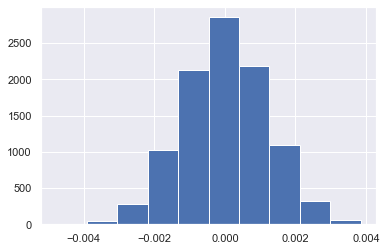

In [29]:
plt.hist(p_diffs);

 I expected to see a normal distribution based on the CLT and that's what I see!

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
obs_diffs = df2.query('group == "treatment"')['converted'].mean()-df2.query('group == "control"')['converted'].mean()
obs_diffs

-0.0015782389853555567

In [31]:
#at this stage it is easy to calculate the p-value:
(np.array(p_diffs) > obs_diffs).mean()

0.9036

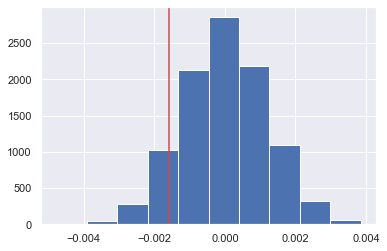

In [32]:
plt.hist(p_diffs);
plt.axvline(obs_diffs, c = 'r');

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here.** <br>

* We caculated the difference in conversion rates of the control group and the converted groups. This is the observed difference that is used to obtain the p-value and draw conclusions on null hypothesis.  
* The calculated p-value is 0.9053. Assuming the error rate (type I error) of 0.05, the p-value is much larger than this value (i.e., $p_{val} > \alpha $). The results is not statistically significant. Based on this result we fail to reject $H_0$.What this means is we cannot establish that the new website is any better that the old website.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" and converted == 1').shape[0]
convert_new = df2.query('group == "treatment" and converted == 1').shape[0]
n_old = df2.query('group == "control"').shape[0]
n_new = df2.query('group == "treatment"').shape[0]
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [34]:
z_score, p_val = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print('{0:0.3f}'.format(z_score))
print('{0:0.3f}'.format(p_val))
# z_score, p_value

1.311
0.905


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**
- The z-test essentiall tells us the number of standard deviations the observed data is from the mean.since the z-test is 1.311, the observed difference is between the 1st and 2nd standard deviation. Furthermore, the p-val is in the z_score value.
- In part j and k, the p-value was found to be 0.9053 which agree well with p-val obtain in part m, 0.905. Based on this outcome, we again fail to reject the null hypothesis and conclude that the old page is same or better than the new page. 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.** <br>
-Logistic regression needs to be used because the outcome (dependent variable) has only a limited number of possible values (in this case, its either converted or not converted. Linear regression is mainly used for continuous dependent variables like height, weight, etc.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
df3 = df2.copy()
df3.head(3)

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1


In [36]:
df3['intercept']=1

In [37]:
df3[['ab_page','treatment']] = pd.get_dummies(df3.group)
df3 = df3.drop('treatment', axis = 1)
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [38]:
logmod = sm.Logit(df3.converted, df3[['intercept', 'ab_page']])
result = logmod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 19 Dec 2019   Pseudo R-squ.:               8.077e-06
Time:                        21:42:03   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0038      0.008   -247.146      0.000      -2.020      -1.988
ab_page        0.0150      0.011      1.311      0.190      -0.007       0.037
==============================================================================
"""

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

- The model is an exponential model. Thus every coefficient and intercep needs to be exponetiated to have a proper meaning.

In [39]:
b0 = 1/np.exp(-2.0038) 
b1 = np.exp(0.0150)  
b0, b1

(7.4171879287312485, 1.015113064615719)

- What this means is for every 1 unit increase in ab_page (or every one treatment unit), the conversion is 1.01511 times as likely given that all the other condition do not change.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Put your answer here.** <br>
-The p-value associated with the `ab_page` is 0.19.
-In part II, we chose $H_0$ and $H_1$ so that to turn the p-value into a one-sided tail. However, in part III, the model is a two tail regression test. It checks to see if the new change has any effect or not (i.e., the null hypothesis is defined as $H_0: p_{new} = p_{old}$ . We can convert this to a one-sided tail by $[1-\frac{1}{\frac{0.19}{2}}]=0.95$. This is close to the value we obtained from part II.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**
- Including other things that might influence the outcome would make out model more robust and result in a more solid conclusion. Date and time information, for example, may give us more information on where or not the have influence on people's decisions on converting to the new page or not.
- When more variables are added, there is always that chance that we get variable co-dependencies. 


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [40]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df3.set_index('user_id'), how='inner')

In [41]:
df_new.head(2)

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0


In [42]:
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [43]:
### Create the necessary dummy variables
df_new[['UK', 'US', 'CA']] = pd.get_dummies(df_new.country)
df_new = df_new.drop('CA', axis = 1) #Dropt the CA
df_new.head(3)

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,0,1


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [44]:
### Fit Your Linear Model And Obtain the Results
Log_model = sm.Logit(df_new.converted, df_new[['intercept','ab_page','UK','US']])
result = Log_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 19 Dec 2019   Pseudo R-squ.:               2.323e-05
Time:                        21:42:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0042      0.009   -224.560      0.000      -2.022      -1.987
ab_page        0.0149      0.011      1.307      0.191      -0.007       0.037
UK            -0.0408      0.027     -1.516      0.130      -0.093       0.012
US             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [45]:
#exponentiate the result for intrepretation
1/np.exp(-2.0042), np.exp(0.0149), 1/np.exp(-0.0408), np.exp(0.0099)

(7.420155397356899, 1.0150115583846535, 1.0416437559600236, 1.0099491671175422)

- Base on the coefficients, for every unit increase in ab_page, there is 1.015 time as likely to have conversion, which is not very significant. for every unit increase in UK, there is a 1.0416x decrease and for every unit increase in US there is 1.01x increase in US, given everything else stays the same.
- However, there p-value is large, and none of them are significant. This usually tells that there might be multicolinearity. 
There are two ways to know this: (a) using use scatter plot matrix to visually observe the co-dependencies and (b)use VIF and remove one with least interest.

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 
